# Solving a discrete fracture model on fractures defined via multiple level sets

reference: https://www.sciencedirect.com/science/article/pii/S0021999120302977
+ discrete fracture model on nonmatching grids

+ PDE: single phase flow in fractured media (hybrid-dimensional representation)
$$
-\nabla\cdot (\mathbf K\nabla p) = f,\quad \in\Omega\\
\mathbf K = \mathbf K_m + \sum_{i=1}^L \epsilon_ik_{fi}\delta_i(\cdot)\mathbb{1}(\cdot)\mathbf v_i\mathbf v_i^T,
$$
where $p$ is the pressure, $\mathbf K$ is the permeability tensor that consists of the permeability tensor in the porous matrix
$\mathbf K_m$, and 
the permeability tensor in $i$-th fracture 
$\mathbf K_{fi}=\epsilon_ik_{fi}\delta_i(\cdot)\mathbb{1}(\cdot)\mathbf v_i\mathbf v_i^T
$,
with $\epsilon_i$ being the thickness of the fracture strip, $k_{fi}$ the tengential permeability in the fracture, $\delta_i(\cdot)\mathbb{1}(\cdot)$ being the indicator function for the fracture, and 
$\mathbf v_i$ the tangential direction on the fracture.

+ A conforming FEM for the above discrete fracture model on nonmatching grids are given as follows:
Find $p_h\in V_h\subset H^1(\Omega)$ s.t.
$$
\int_{\Omega}\mathbf{K}_m
\nabla p\cdot\nabla v\mathrm{dx}+\sum_{i=1}^L \int_{\Gamma_i}\epsilon_ik_{fi}\nabla_{\Gamma}p\cdot \nabla_{\Gamma}v\mathrm{ds}=
\int_{\Omega}fv\mathrm{dx}, \quad \forall v\in V_h,
$$
where $\Gamma_i$ denotes the $i$-th fracture, and $\nabla_{\Gamma}$ the tangential gradient.

+ We use different multi levelsets to represent $\Gamma_i$

## Testcase: complex fracture network. Example 5.6 in the above reference 
See also benchmark data from https://git.iws.uni-stuttgart.de/benchmarks/fracture-flow/

+ Domain with fracture (and boundary conditions):
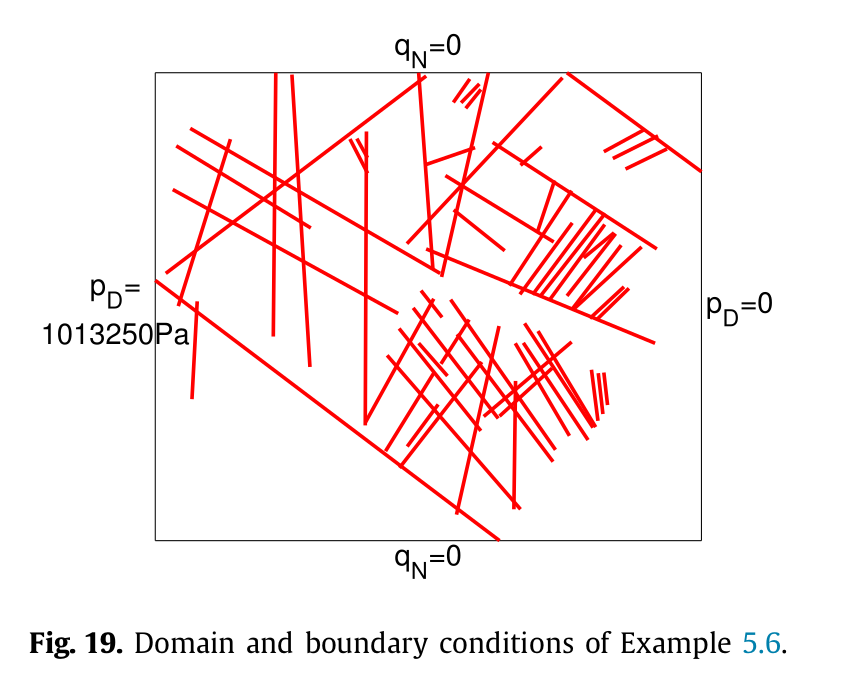
+ 63 fractures represented by line segments
+ Each line segment will be represented by a multilevelset function that is a line and a circle (a line segment is the intersection of a line hyperplane cut by interior of a circle)
+ Permeability: $\mathbf K_m=1e-14$, $\epsilon_ik_{fi} = 1e-10$
+ Domain size: [0,700]x[0,600]

In [1]:
# Basic NGSolve things
from netgen.geom2d import SplineGeometry
from ngsolve import *

# ngsxfem and the mlset convenience layer 
from xfem import *
from xfem.mlset import *

import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# reference data from motardfm
ref1 = np.loadtxt('data/mortardfm_real_x625.csv',comments='#',delimiter=',',skiprows=1)
ref2 = np.loadtxt('data/mortardfm_real_y500.csv',comments='#',delimiter=',',skiprows=1)

## 1) CG: nonconforming mesh

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

# DOFS: 13751


Text(0, 0.5, 'pressure')

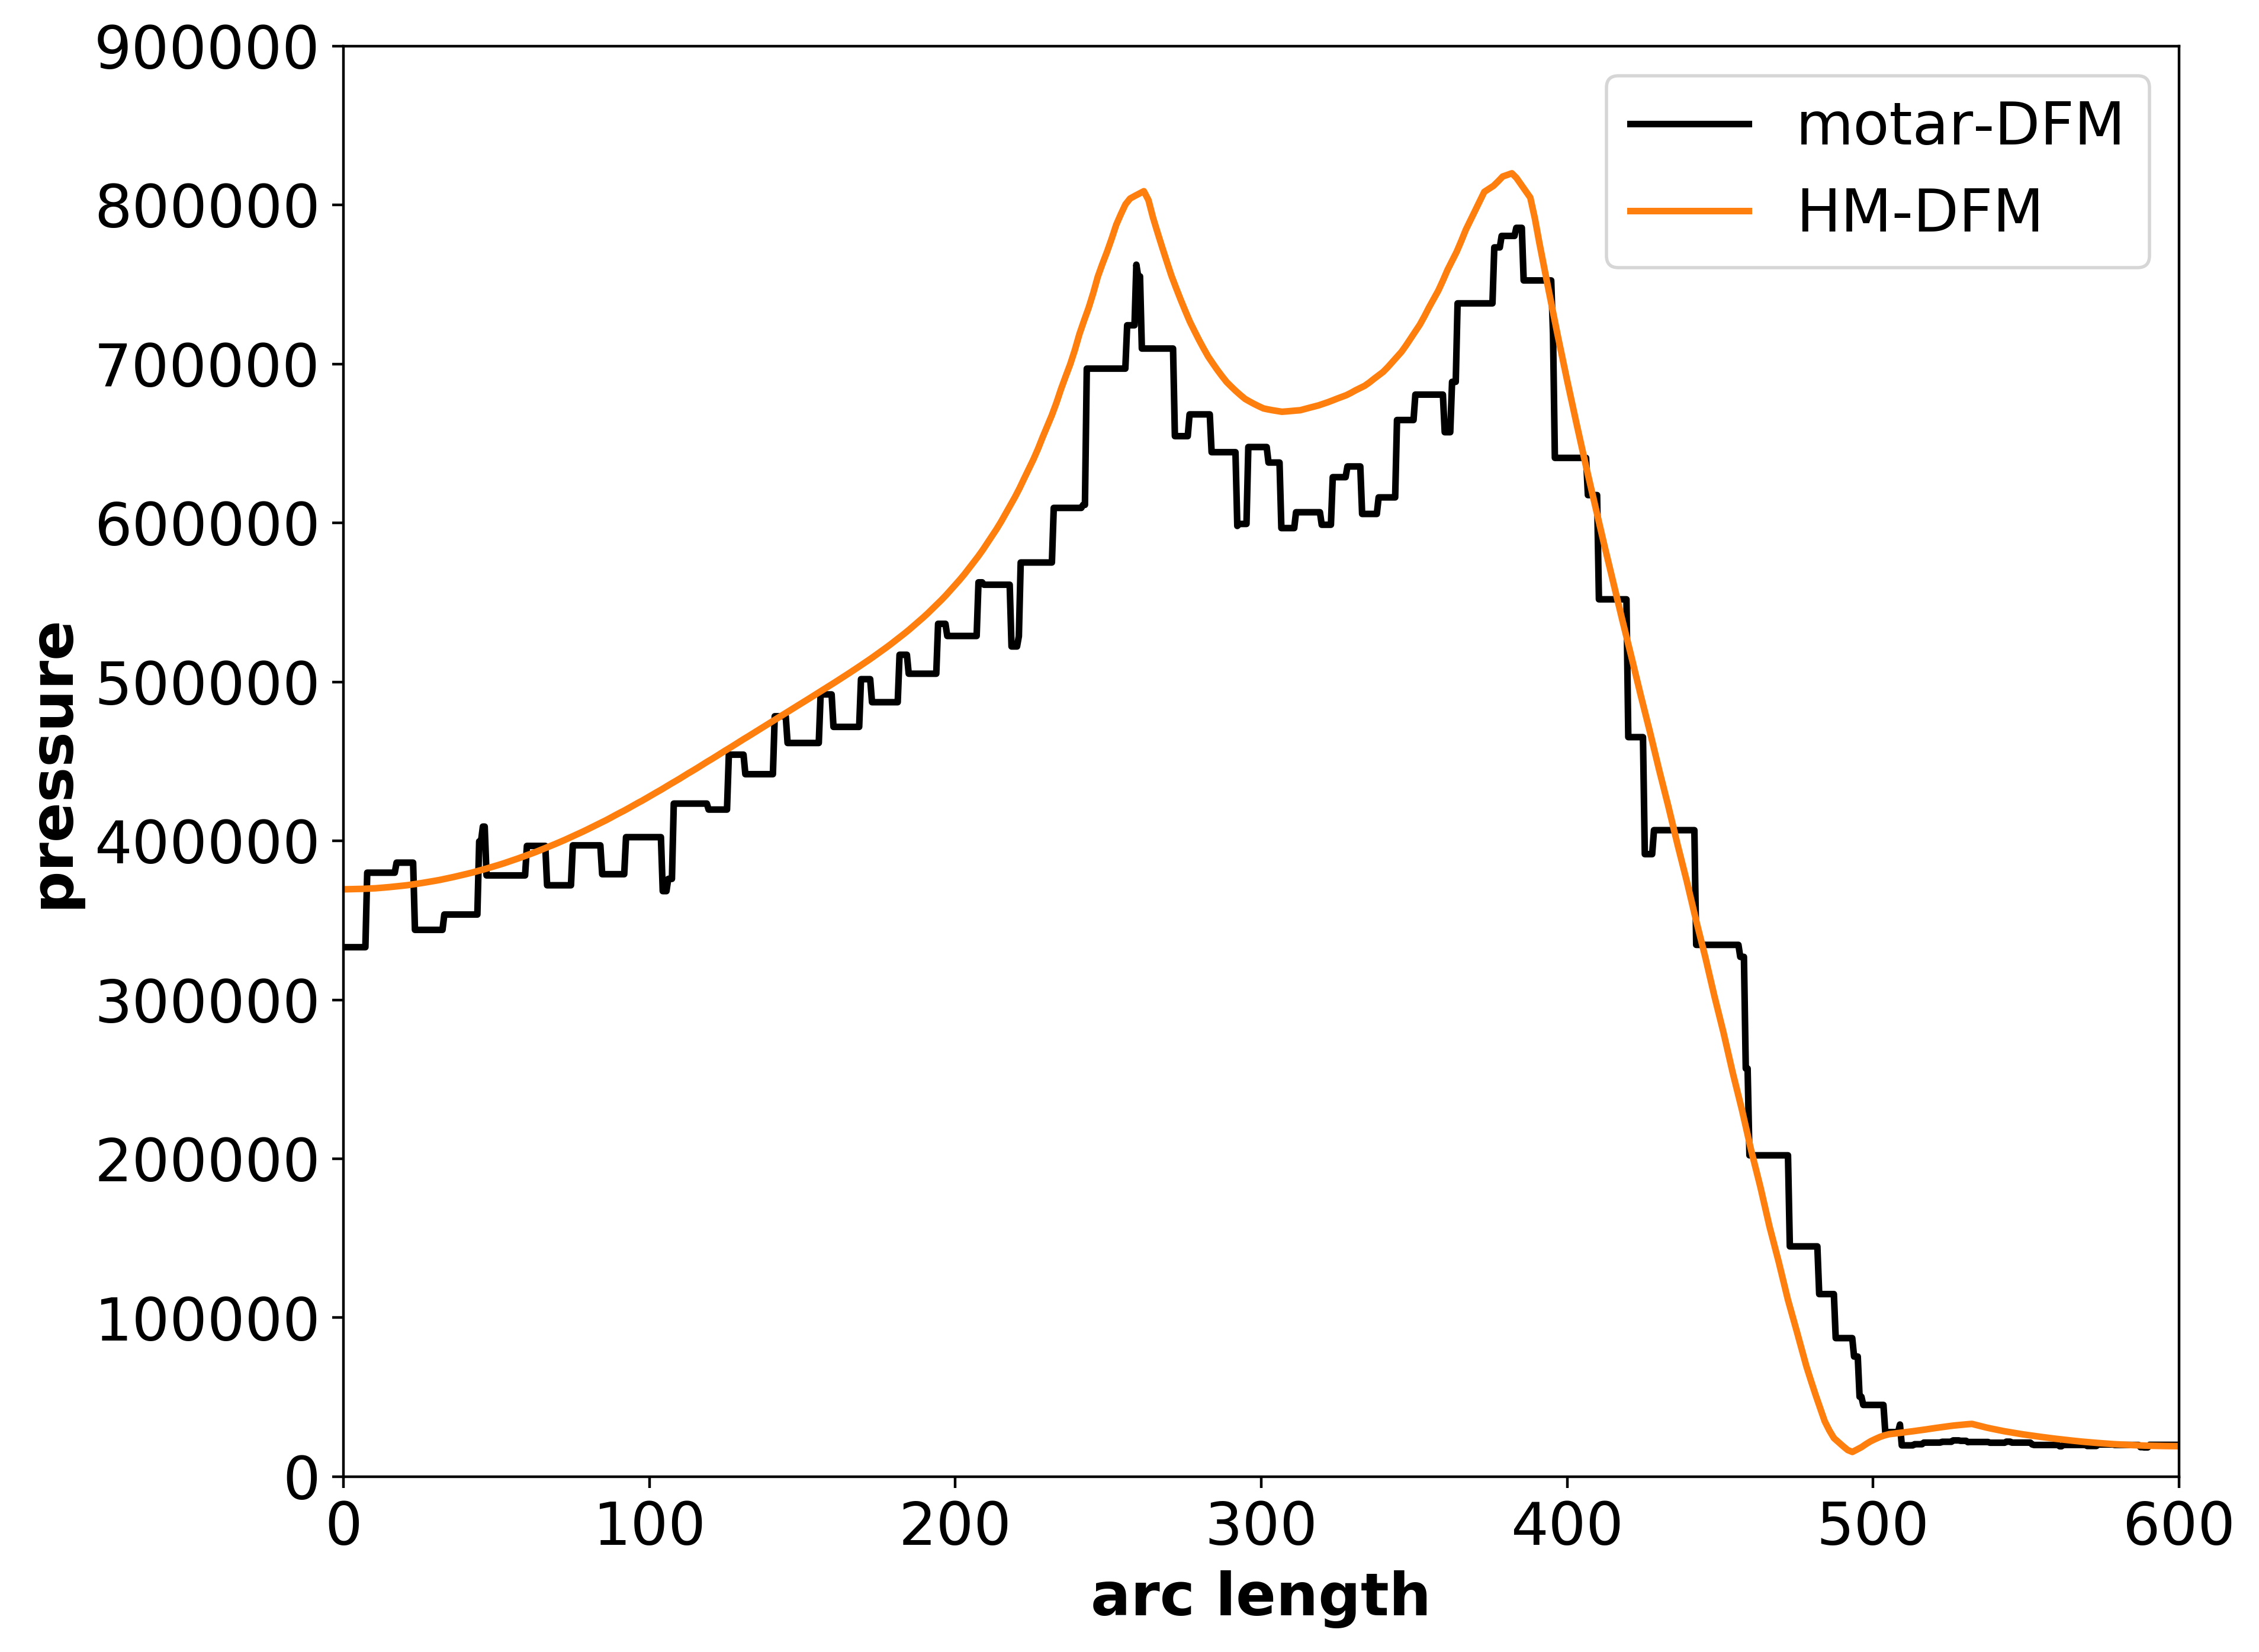

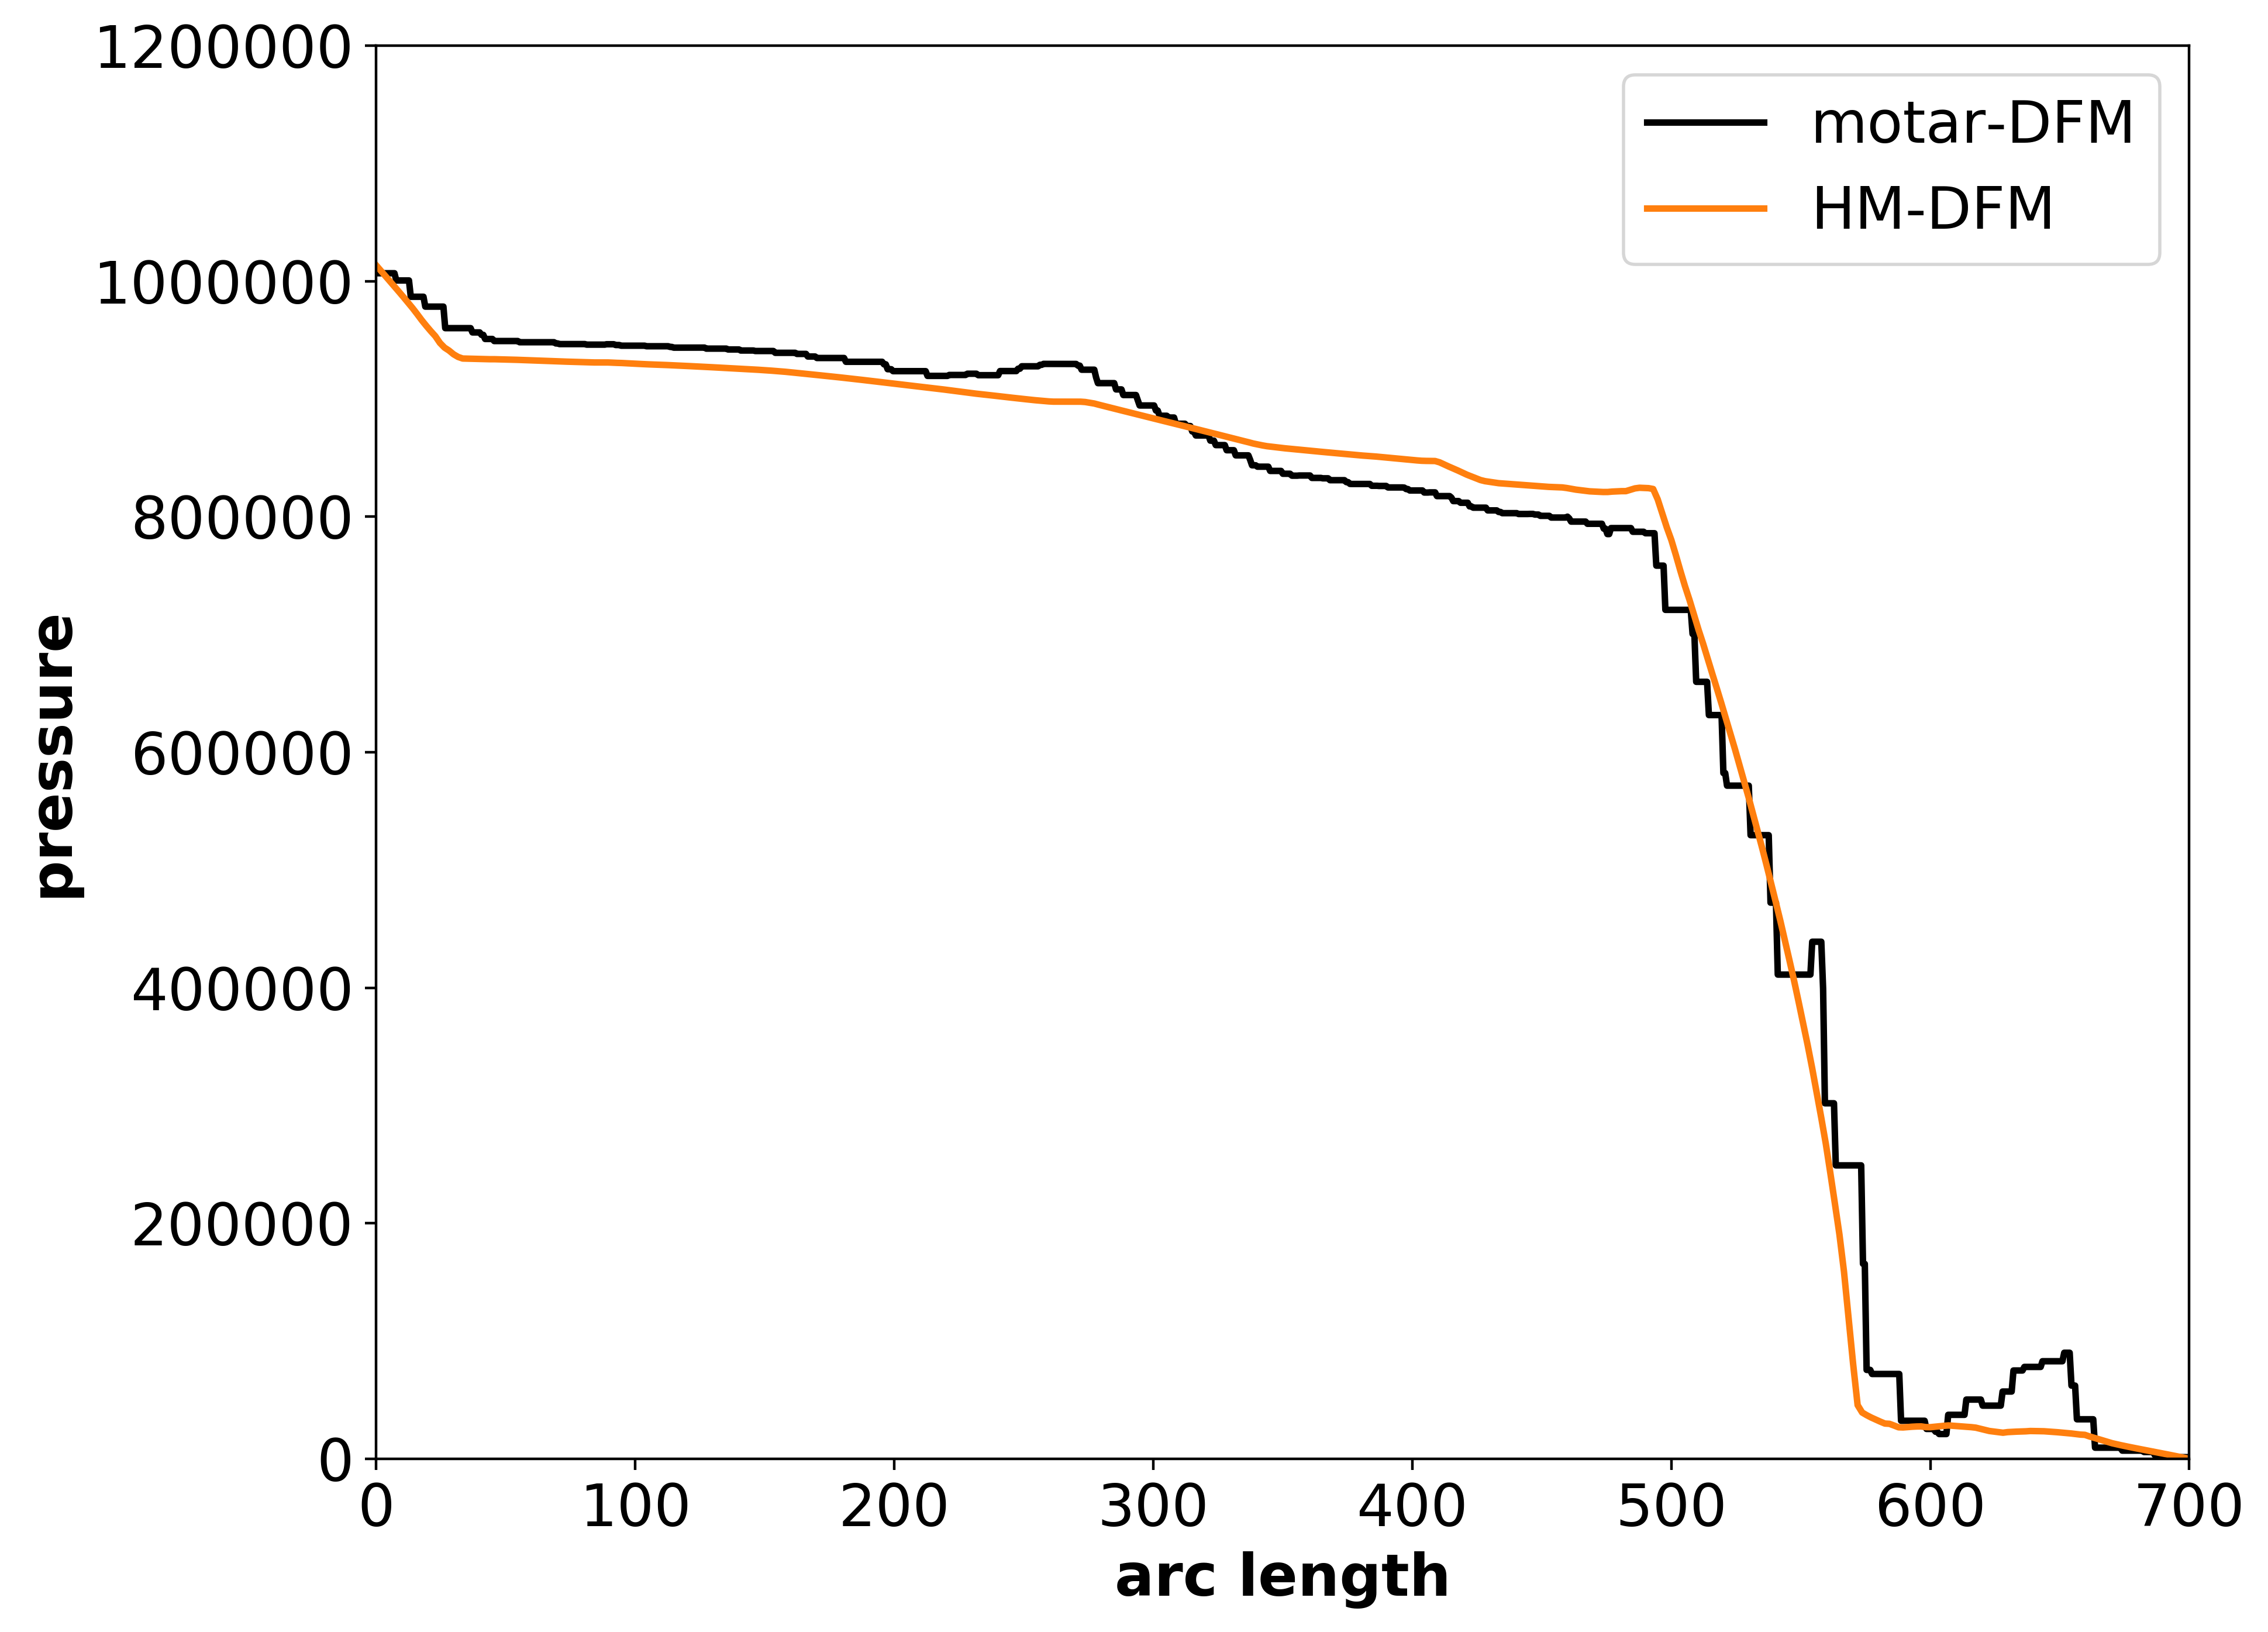

In [2]:
### fracture network
geo = SplineGeometry()
geo.AddRectangle((0, 0), (700, 600), 
                 bcs=("bottom", "right", "top", "left"), 
                leftdomain=1, rightdomain=0)
mesh = Mesh(geo.GenerateMesh(maxh=6))
# fracture network end points
frac0 = np.loadtxt('data/network.csv',comments='#',delimiter=',',skiprows=1)

# number of fractures
nfs = int(frac0[-1][0]) 
# each fracture is represented by a mlset with 2 level set functions (line+circle)
level_sets_p1 = tuple(tuple(GridFunction(H1(mesh, order=1)) for i in range(2)) for j in range(nfs))

# interface indicator/interface elements/tangential directions
lset_ifs = [None for j in range(nfs)]
lset_elems = [None for j in range(nfs)]
ts = [None for j in range(nfs)]
ns = [None for j in range(nfs)]

# all fractures
for i, lset_p1 in enumerate(level_sets_p1):
    x0, y0, x1, y1 = frac0[i][1], frac0[i][2],frac0[i][3],frac0[i][4]
    l1 = (x-x0)/(x1-x0)-(y-y0)/(y1-y0)
    len1 = sqrt((x1-x0)**2+(y1-y0)**2)
    xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
    r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
    InterpolateToP1(l1, lset_p1[0]) # line segment
    InterpolateToP1(r1, lset_p1[1]) # circ
    mlci = MultiLevelsetCutInfo(mesh, lset_p1)
    frac = DomainTypeArray((IF, NEG))
    lset_ifs[i] = {"levelset": lset_p1, "domain_type": frac, "subdivlvl" : 0}
    lset_elems[i] = mlci.GetElementsWithContribution(frac)
    n1 = 1.0/grad(lset_p1[0]).Norm() * grad(lset_p1[0])
    ts[i] = CoefficientFunction((-n1[1], n1[0]))
    ns[i] = n1
    if i ==0:
        bitarray = BitArrayCF(lset_elems[i])
    else:
        bitarray += BitArrayCF(lset_elems[i])

# draw the interface elements for the fracture
# Draw(bitarray, mesh, max=1)
# CG on nonconforming grids
fes = H1(mesh, order=1, dirichlet="left|right")
K0, epsK1 = 1e-14, 1e-10 # ratio is 10^4

u,v = fes.TnT()
a = BilinearForm(fes, symmetric=True)
a += K0*grad(u)*grad(v)*dx

# level set contribution
for i in range(nfs):
    a += SymbolicBFI(levelset_domain = lset_ifs[i], 
                 form = epsK1 * grad(u)*ts[i] * grad(v)*ts[i],
                definedonelements=lset_elems[i])

f = LinearForm(fes)
gfu = GridFunction(fes)

a.Assemble()

# left dirichlet data
gfu.Set(1013250, definedon=mesh.Boundaries("left"))
f.vec.data -= a.mat*gfu.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs())*f.vec

Draw(gfu, mesh, "soln")
print("# DOFS:", fes.ndof)

# compare data on cut lines with other methods (a mortar DFM with 25k elems)
# see the above benchmark link for more methods
xx = np.linspace(0, 700, 400)
yy = np.linspace(0, 600, 400)
pre1 = np.array([gfu(mesh(xx0,500)) for xx0 in xx])
pre2 = np.array([gfu(mesh(625,yy0)) for yy0 in yy])

plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref1.T[2], ref1.T[0], "k", linewidth=2)
plt.plot(yy, pre2, 'C1', linewidth=2)
plt.legend(["motar-DFM", "HM-DFM"])
plt.axis([0,600, 0,0.9e6])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
# plt.savefig("data/realA.pdf", dpi=400)


plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref2.T[3], ref2.T[0], "k", linewidth=2)
plt.plot(xx, pre1, 'C1', linewidth=2)
plt.legend(["motar-DFM", "HM-DFM"])
plt.axis([0,700, 0,1.2e6])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
# plt.savefig("data/realB.pdf", dpi=400)


## 2) CG: conforming mesh

matrix elements:  10807 ; fracture elements:  1047


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Text(0, 0.5, 'pressure')

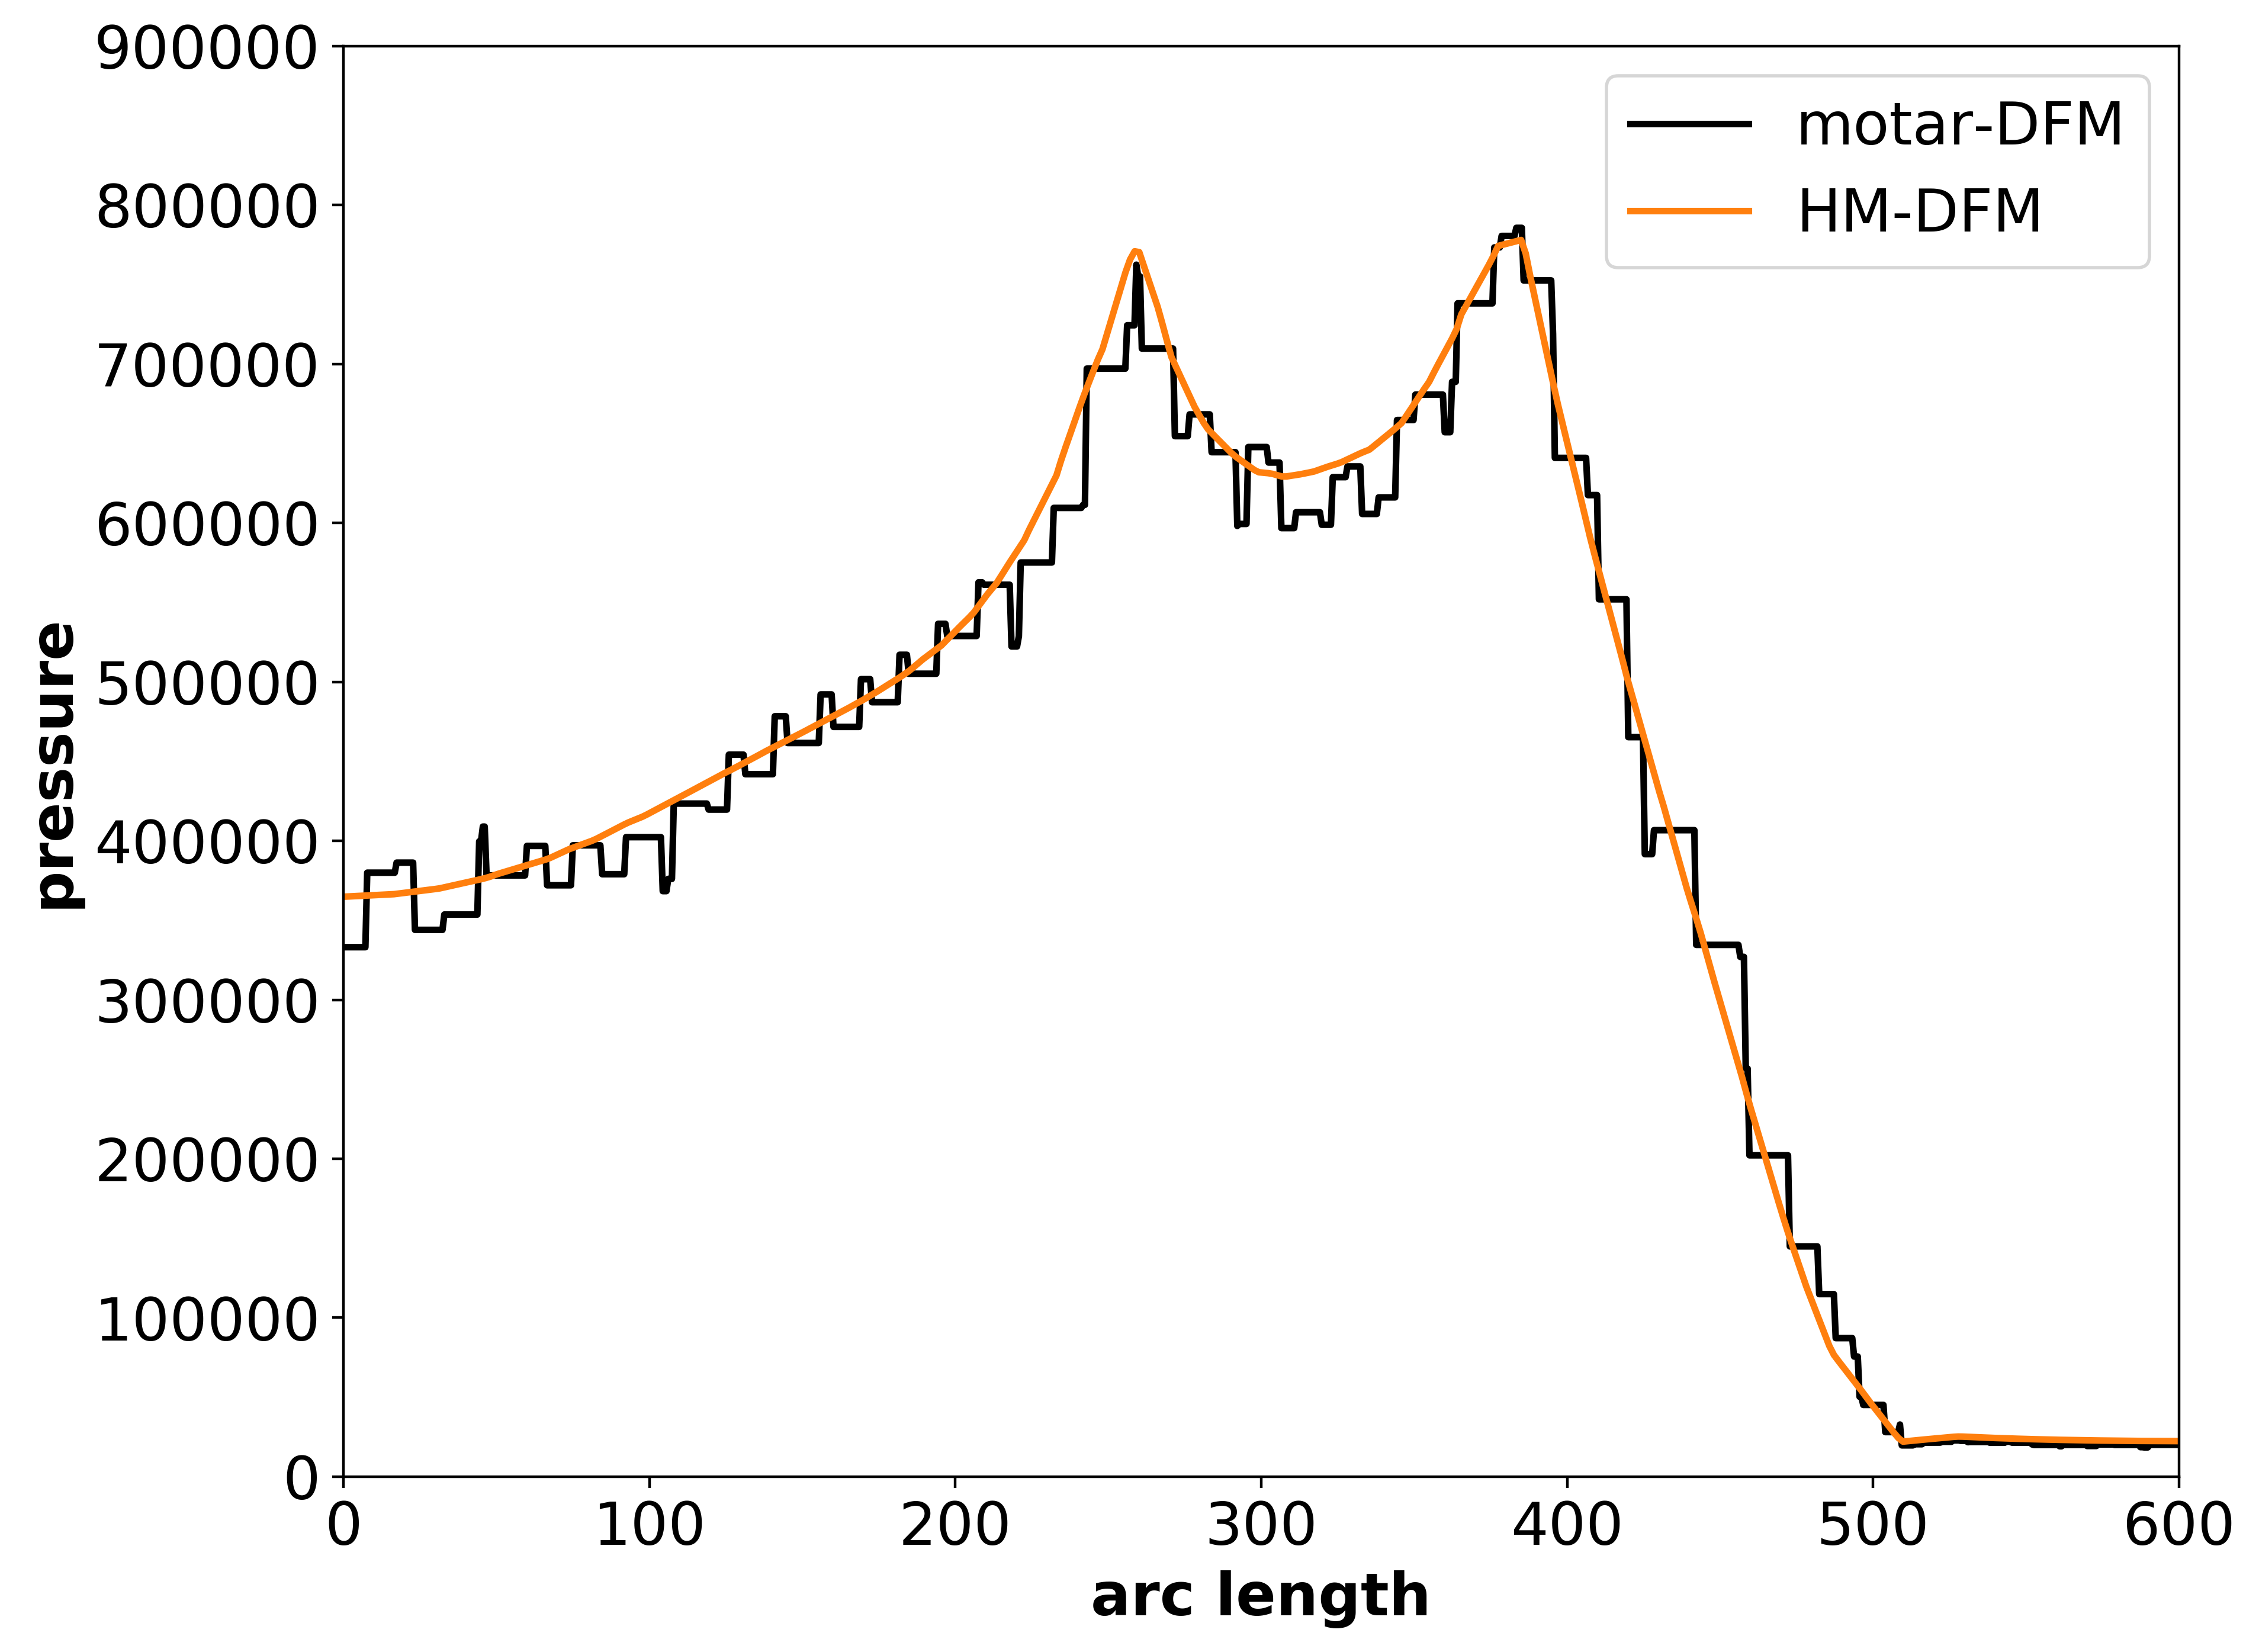

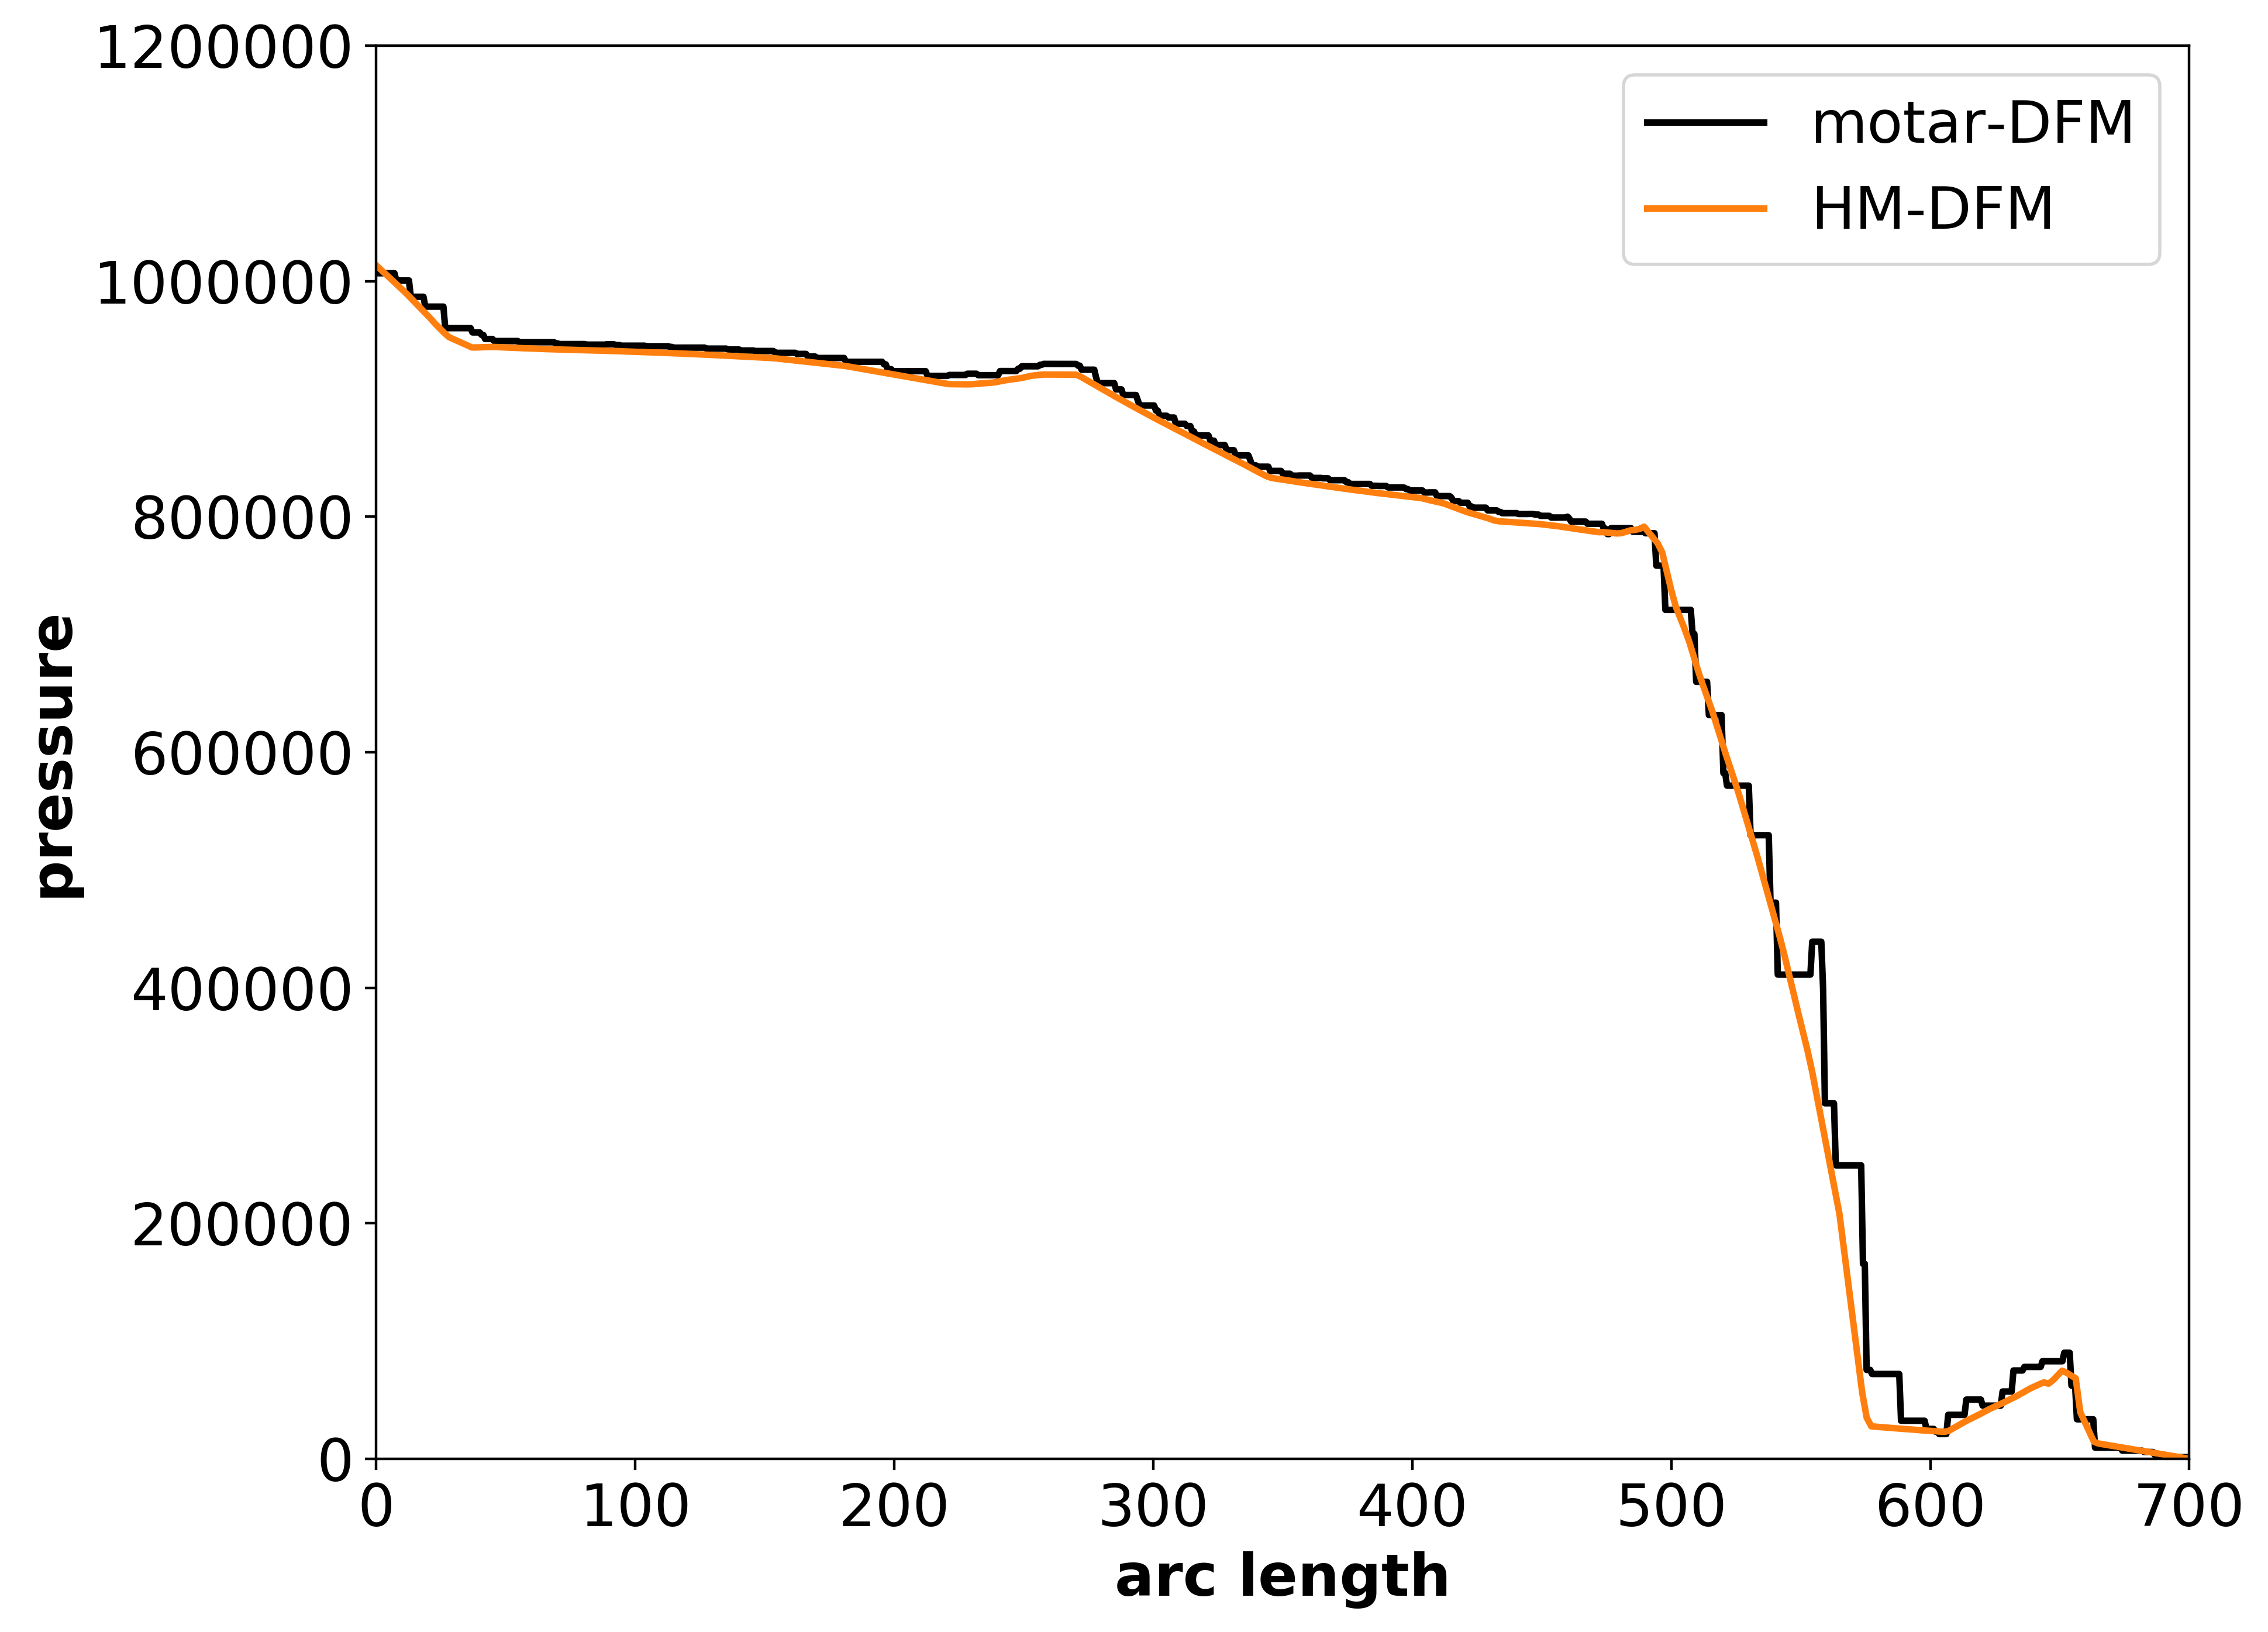

In [3]:
# CG on conforming grid
from read_gmsh import ReadGmsh

# import the Gmsh file to a Netgen mesh object
# mesh = ReadGmsh("mesh/ccdfm_real.msh")
mesh = ReadGmsh("mesh/boxdfm_real.msh")
mesh = Mesh(mesh)

eps = 1e-6
for e in mesh.Elements(BND):
    p0 = mesh[e.vertices[0]].point
    p1 = mesh[e.vertices[1]].point
    if abs(p0[0]-0)<eps and abs(p1[0]-0)< eps:
        mesh.ngmesh.SetBCName(e.index, "left")
    elif abs(p0[0]-700)<eps and abs(p1[0]-700)< eps:
        mesh.ngmesh.SetBCName(e.index, "right")
    elif abs(p0[1]-600)<eps and abs(p1[1]-600)< eps:
        mesh.ngmesh.SetBCName(e.index, "top")
    elif abs(p0[1]-0)<eps and abs(p1[1]-0)< eps:
        mesh.ngmesh.SetBCName(e.index, "bottom")
    else:
        mesh.ngmesh.SetBCName(e.index, "frac")

V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac")))
print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)
        
gfu = GridFunction(H1(mesh))
gfu.Set(1,definedon=mesh.Boundaries("frac"))
Draw(gfu)

fes = H1(mesh, dirichlet="left|right")
K0, epsK1 = 1e-14, 1e-10 # ratio is 10^4

u,v = fes.TnT()
a = BilinearForm(fes, symmetric=True)
a += K0*grad(u)*grad(v)*dx

a += epsK1*grad(u).Trace()*grad(v).Trace()*ds("frac")

f = LinearForm(fes)
gfu = GridFunction(fes)

a.Assemble()

# top dirichlet data
gfu.Set(1013250, definedon=mesh.Boundaries("left"))
f.vec.data -= a.mat*gfu.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs())*f.vec
Draw(gfu, mesh, "soln")

# compare data on cut lines with other methods (a mortar DFM with 25k elems)
# see the above benchmark link for more methods
xx = np.linspace(0, 700, 400)
yy = np.linspace(0, 600, 400)
pre1 = np.array([gfu(mesh(xx0,500)) for xx0 in xx])
pre2 = np.array([gfu(mesh(625,yy0)) for yy0 in yy])

plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref1.T[2], ref1.T[0], "k", linewidth=2)
plt.plot(yy, pre2, 'C1', linewidth=2)
plt.legend(["motar-DFM", "HM-DFM"])
plt.axis([0,600, 0,0.9e6])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
# plt.savefig("data/realA.pdf", dpi=400)


plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref2.T[3], ref2.T[0], "k", linewidth=2)
plt.plot(xx, pre1, 'C1', linewidth=2)
plt.legend(["motar-DFM", "HM-DFM"])
plt.axis([0,700, 0,1.2e6])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
# plt.savefig("data/realB.pdf", dpi=400)


## 3) Hybrid-Mixed: conforming

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  62575  Global:  19347 V:  32421 W:  10807 M:  16228 Vf:  2094 Mf:  1025


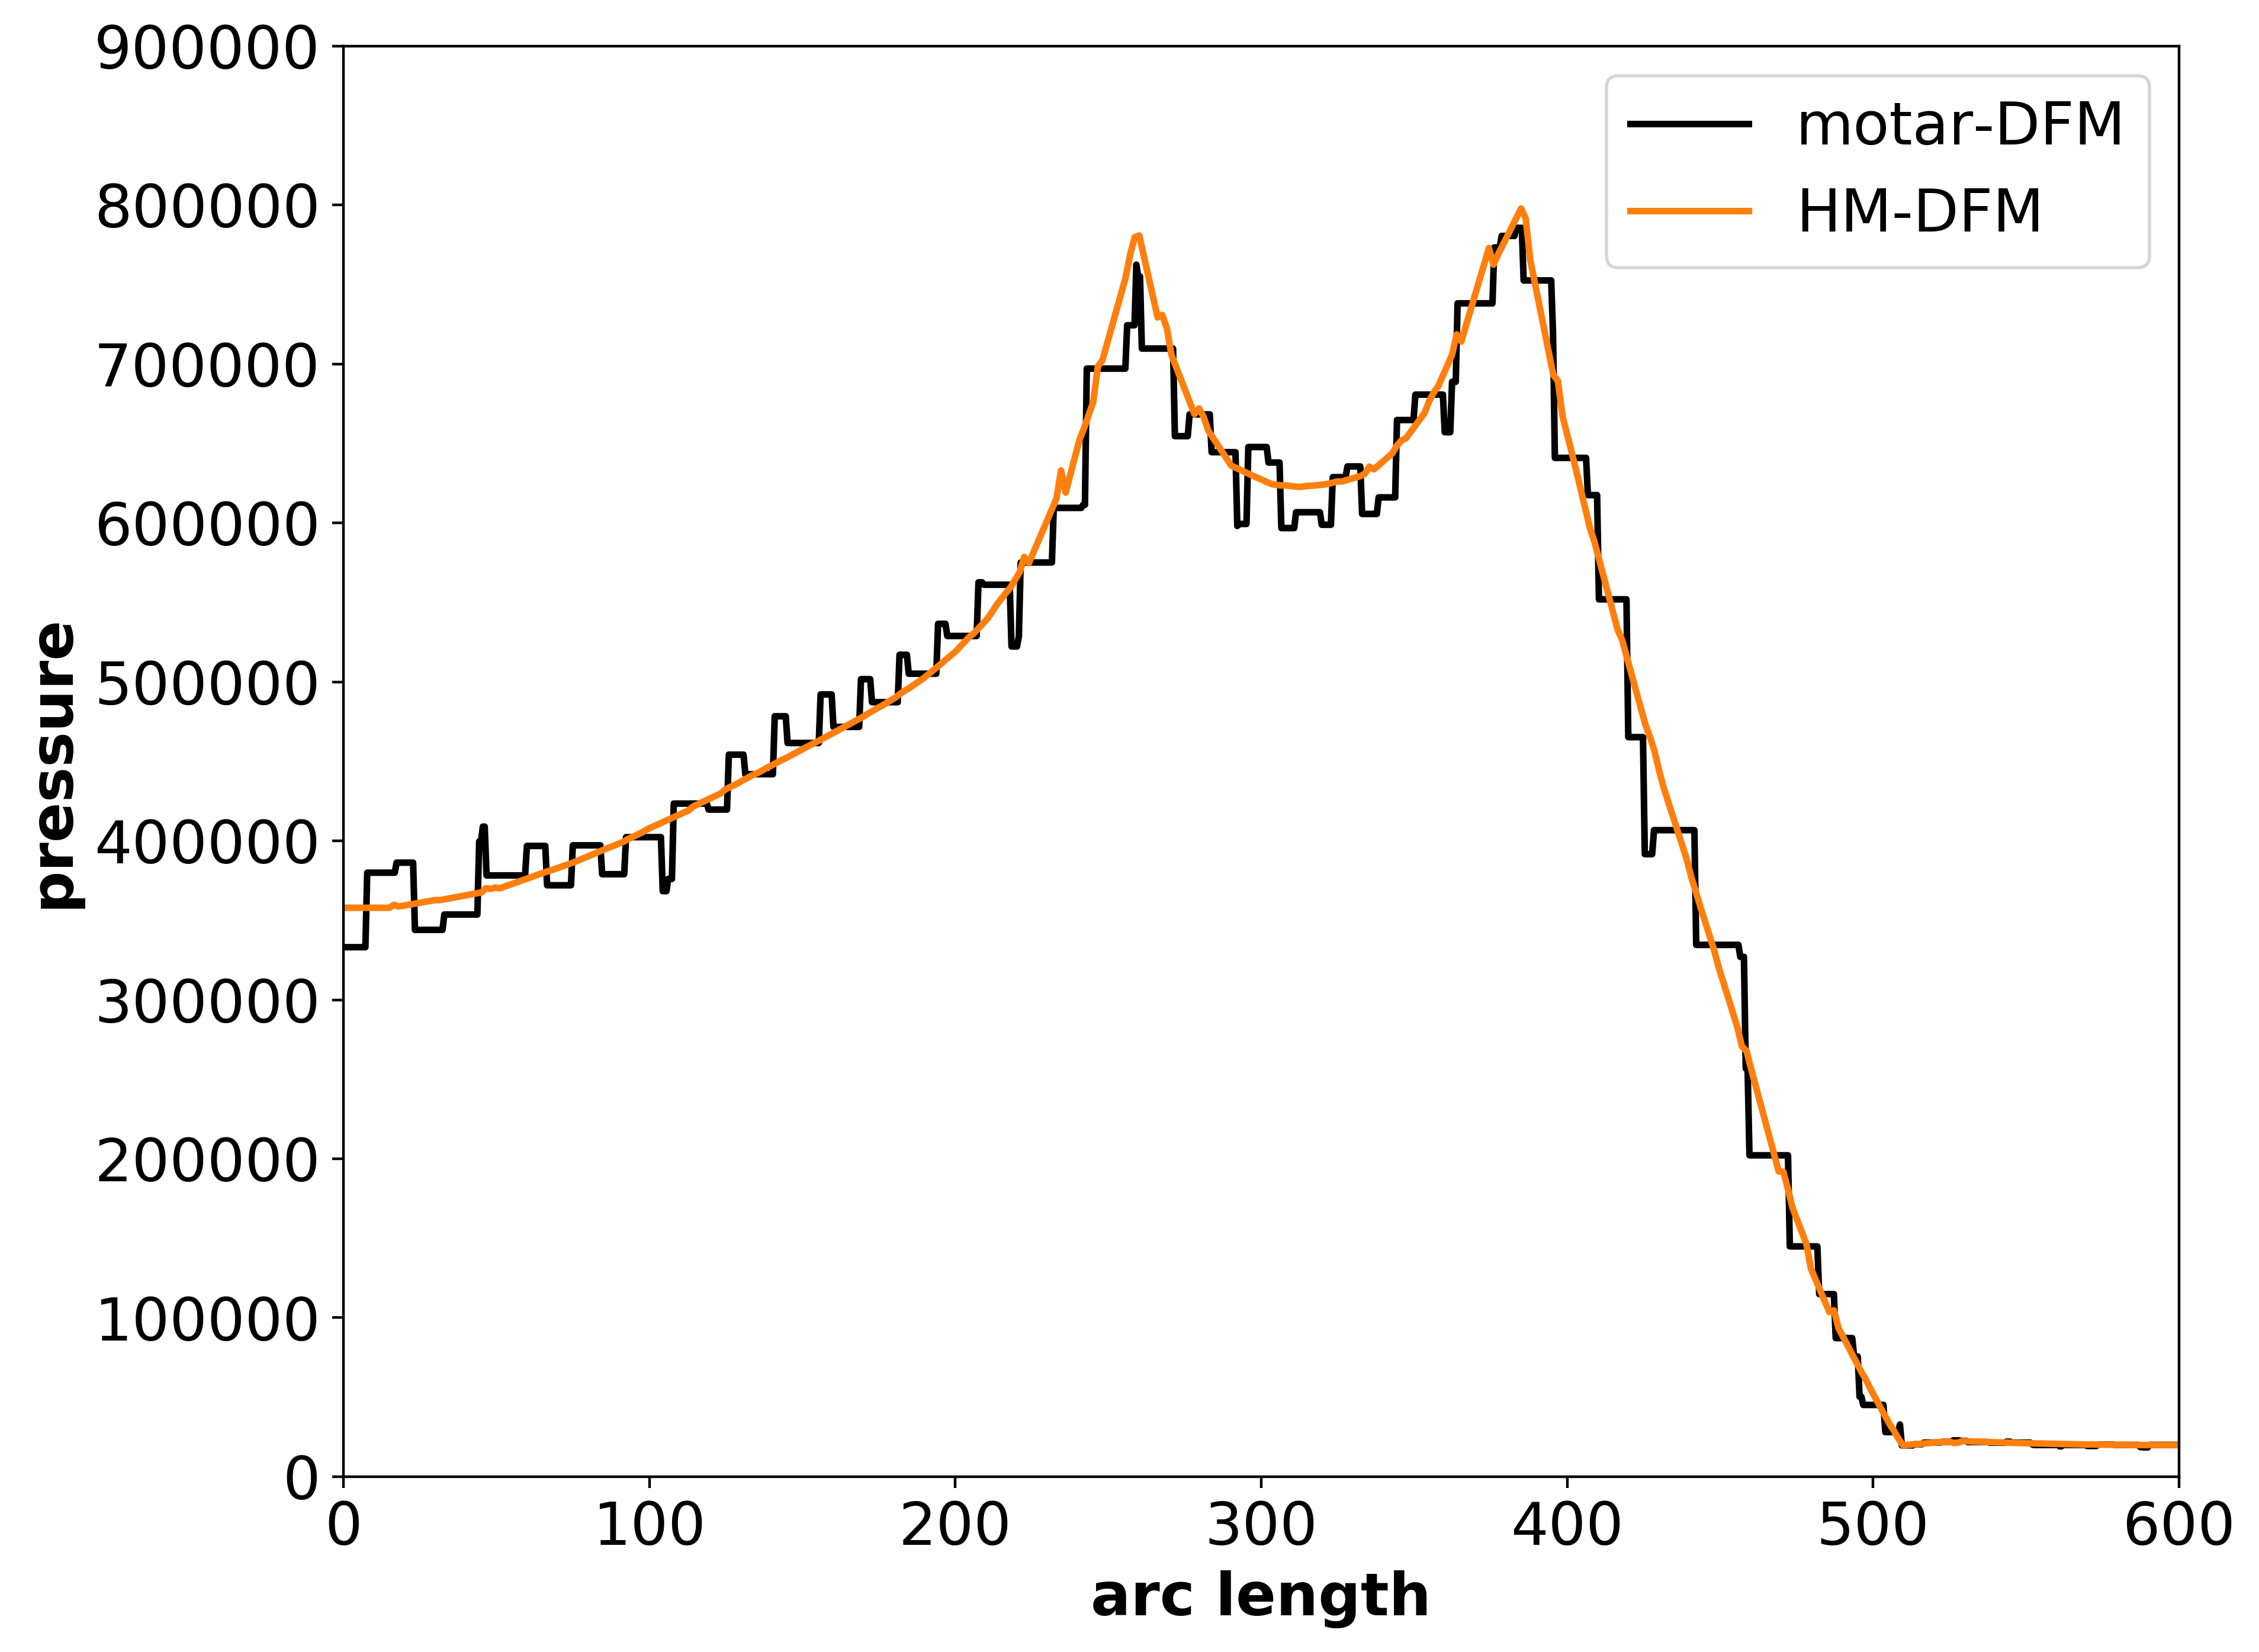

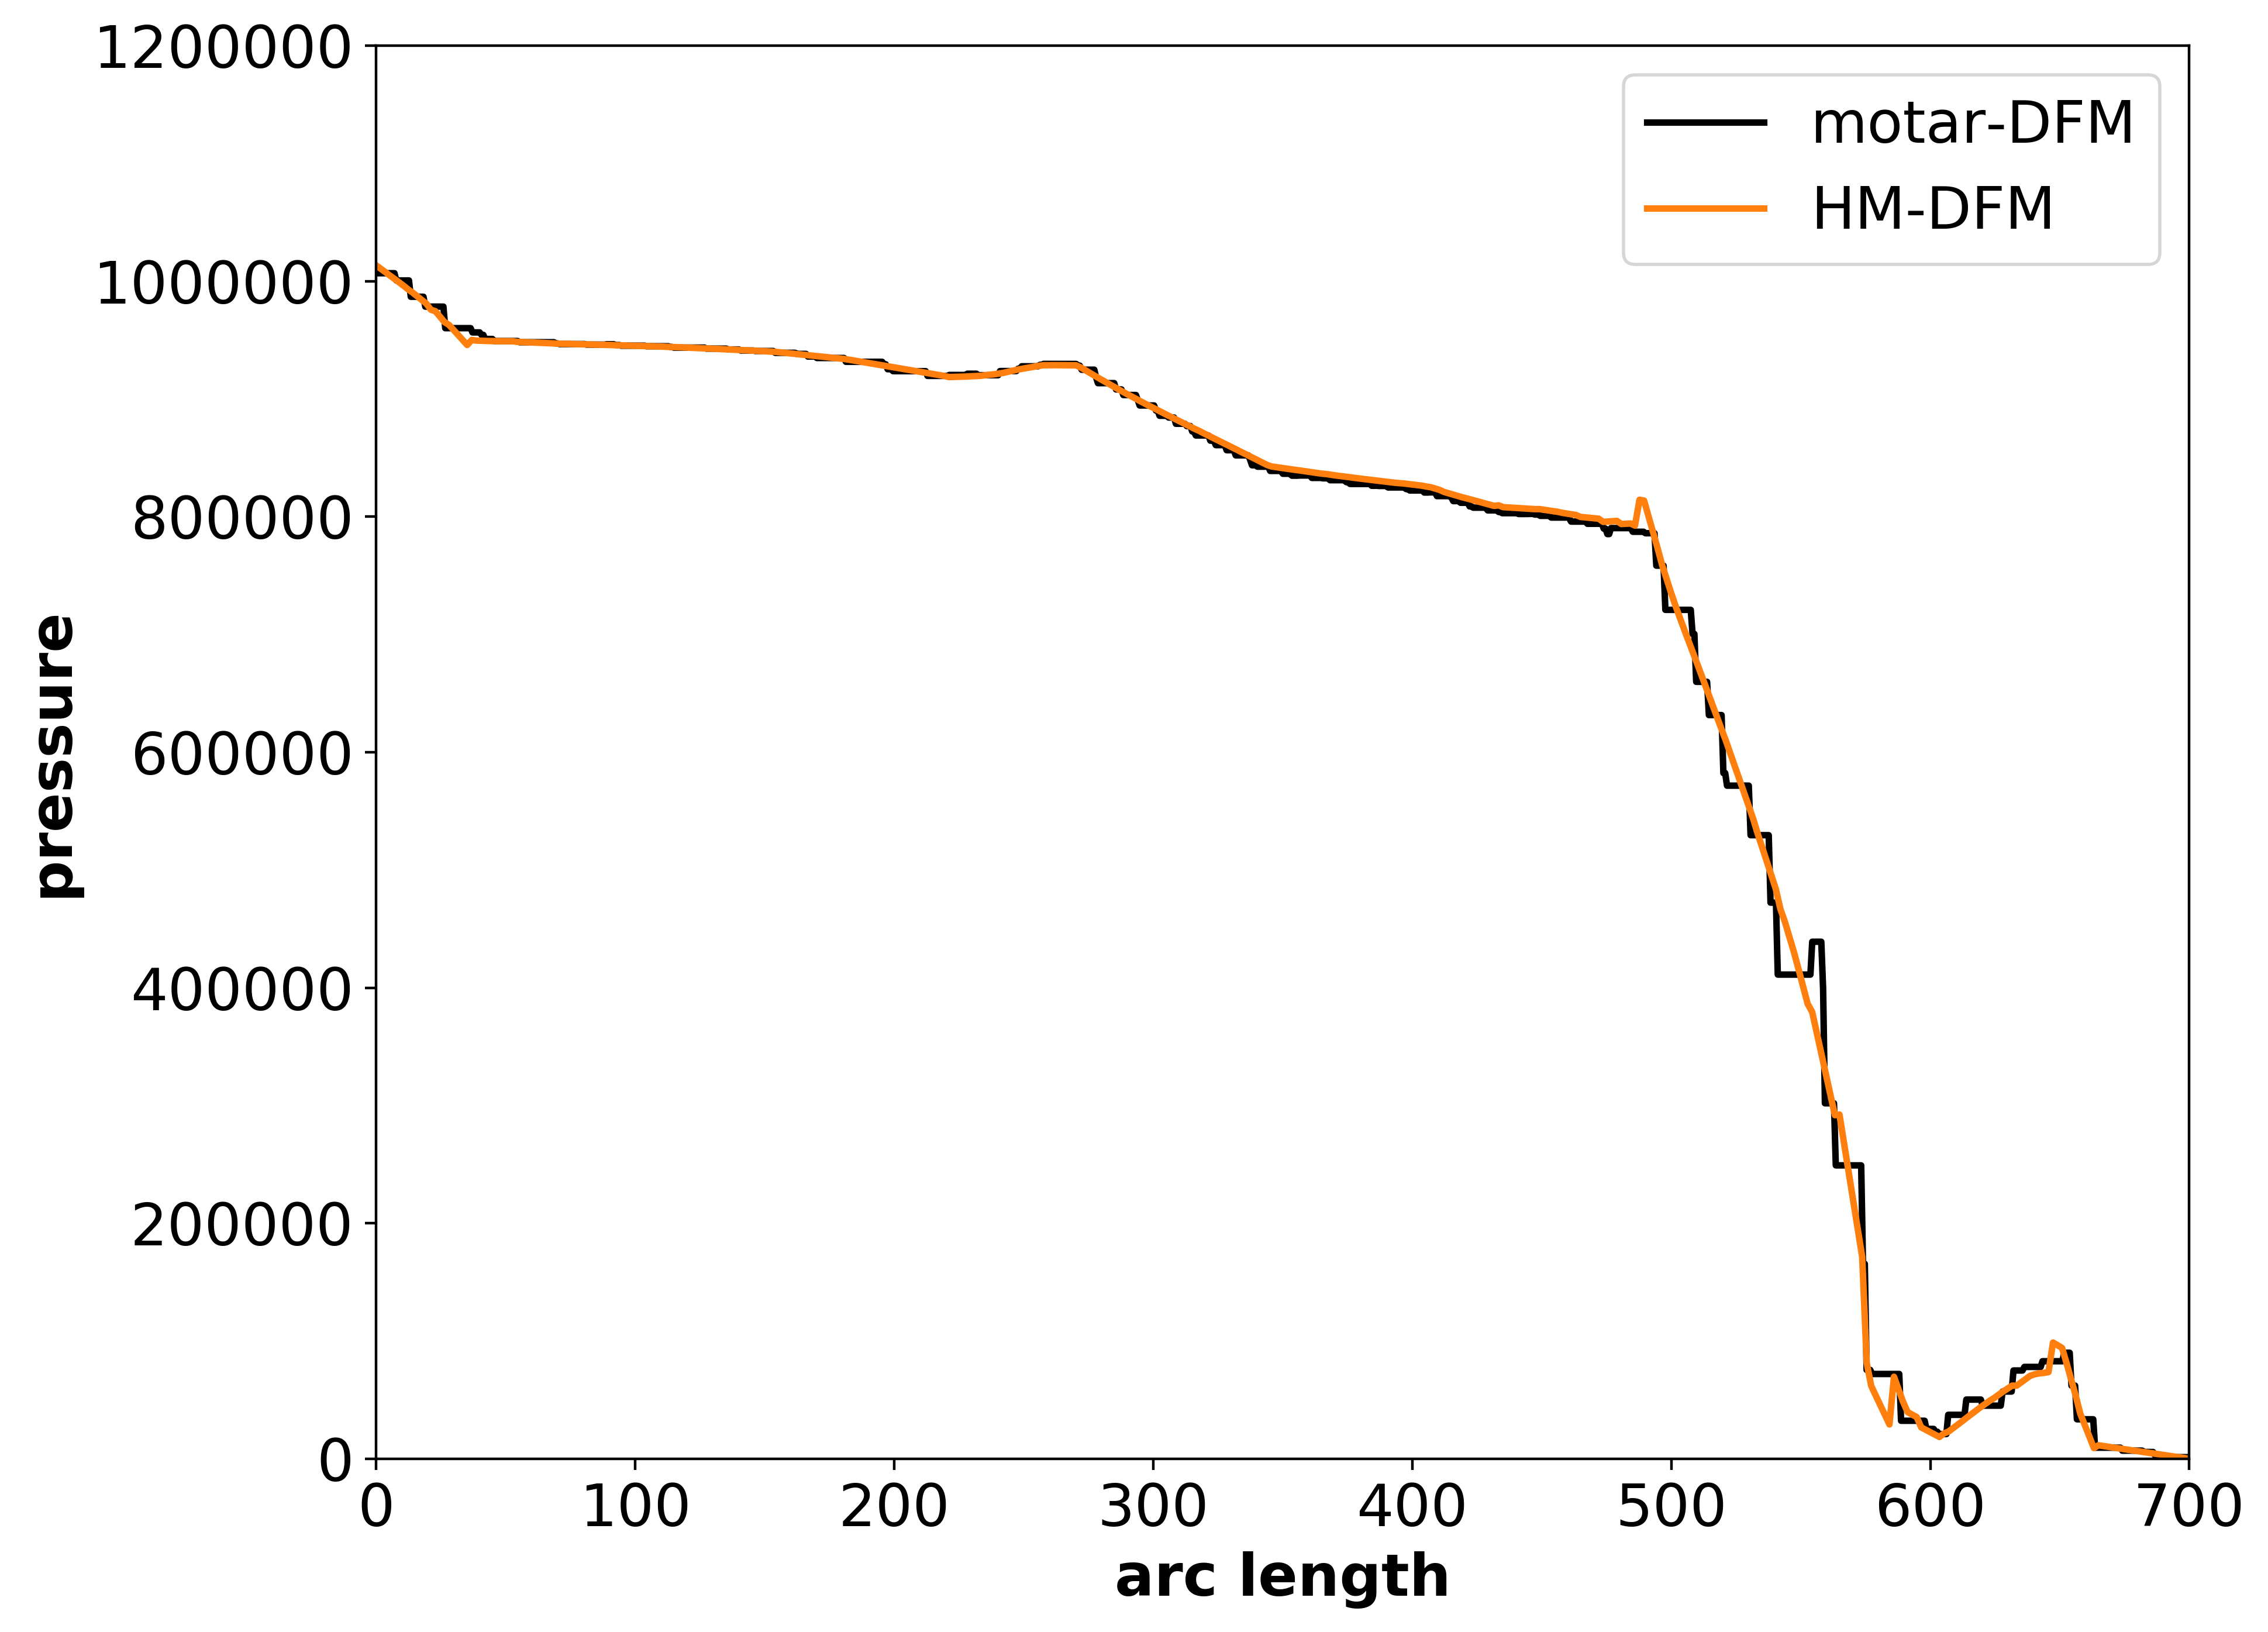

In [4]:
### Hybrid-Mixed on conforming meshes 
order = 0
frac = "frac"
V = HDiv(mesh, order=order, RT=True, discontinuous=True)
W = L2(mesh, order=order)
M = FacetFESpace(mesh, order=order, dirichlet="left|right")
Vf = Compress(SurfaceL2(mesh, order=order+1, definedon=mesh.Boundaries(frac)))
Mf = Compress(H1(mesh, order=1, definedon=mesh.Boundaries(frac)))

fes = V*W*M*Vf*Mf
(u, p, phat, uf, pbar), (v, q, qhat, vf, qbar) = fes.TnT()

K0, epsK1 = 1e-14, 1e-10 # ratio is 10^4

condense=True
a = BilinearForm(fes, condense=condense)
h = specialcf.mesh_size
n = specialcf.normal(2)
t = specialcf.tangential(2)
# t0 = specialcf.tangential(2, consistent=True)
# subdomain 1
a += (1/K0*u*v-p*div(v)-q*div(u))*dx
a += (1/epsK1*uf.Trace()*vf.Trace()-phat.Trace()*grad(vf).Trace()*t-qhat.Trace()*grad(uf).Trace()*t
     )*ds("frac")
a += (v*n*phat+u*n*qhat)*dx(element_boundary=True)

gfn = GridFunction(Compress(SurfaceL2(mesh, order=1, definedon=mesh.Boundaries(frac))))
count = 0
for e in mesh.Elements(BND):
    if e.mat=="frac":
        if e.vertices[0].nr > e.vertices[1].nr:
            gfn.vec[2*count+1] = -1
        else:
            gfn.vec[2*count+1] = 1 
        count += 1    
a += (pbar*vf*gfn+uf*qbar*gfn)*ds(element_boundary=True, definedon="frac")


# Hack Dirichlet BC
gfL = GridFunction(H1(mesh))
gfR = GridFunction(H1(mesh))
gfL.Set(1, definedon=mesh.Boundaries("left"))
gfR.Set(1, definedon=mesh.Boundaries("right"))

# stabilization on left node
pLeft = 1013250
a += 1e8*pbar*qbar*(gfL+gfR)*ds(element_boundary=True, definedon="frac")

########### TODO

f = LinearForm(fes)
f += 1e8*pLeft*qbar*gfL*ds(element_boundary=True, definedon="frac")

gfu = GridFunction(fes)

a.Assemble()
f.Assemble()

# left dirichlet data
gfu.components[2].Set(pLeft, definedon=mesh.Boundaries("left"))

f.vec.data -= a.mat*gfu.vec
if condense==True:
    f.vec.data += a.harmonic_extension_trans * f.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
if condense==True:
    gfu.vec.data += a.harmonic_extension * gfu.vec 
    gfu.vec.data += a.inner_solve * f.vec

    
# Local postprocessing
V2 = L2(mesh, order=1, all_dofs_together=False)
ph = GridFunction(V2)

a2 = BilinearForm(V2)
f2 = LinearForm(V2)

p2, q2 = V2.TnT()
a2 += grad(p2)*grad(q2)*dx
a2.Assemble()
f2 += -1/K0*gfu.components[0]*grad(q2)*dx
f2.Assemble()

V2.FreeDofs()[:mesh.ne]=False
ph.vec[:mesh.ne].data=gfu.components[1].vec
ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec
    
Draw(ph, mesh, "soln")
# save data to vtk format for better visualization
vtkout = VTKOutput(ma=mesh, coefs=[ph], names=["pres"], filename="data/real")
vtkout.Do()

print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
     "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), "M: ", sum(M.FreeDofs()), 
     "Vf: ", sum(Vf.FreeDofs(True)), "Mf: ", sum(Mf.FreeDofs(True)))

# compare data on cut lines with other methods (a mortar DFM with 25k elems)
# see the above benchmark link for more methods
xx = np.linspace(0, 700, 400)
yy = np.linspace(0, 600, 400)
pre1 = np.array([ph(mesh(xx0,500)) for xx0 in xx])
pre2 = np.array([ph(mesh(625,yy0)) for yy0 in yy])

plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref1.T[2], ref1.T[0], "k", linewidth=2)
plt.plot(yy, pre2, 'C1', linewidth=2)
plt.legend(["motar-DFM", "HM-DFM"])
plt.axis([0,600, 0,0.9e6])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig("data/realA.pdf", dpi=400,bbox_inches='tight')


plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref2.T[3], ref2.T[0], "k", linewidth=2)
plt.plot(xx, pre1, 'C1', linewidth=2)
plt.legend(["motar-DFM", "HM-DFM"])
plt.axis([0,700, 0,1.2e6])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig("data/realB.pdf", dpi=400,bbox_inches='tight')